<a href="https://colab.research.google.com/github/amnyday/mini_project/blob/main/%EC%98%81%ED%99%94%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%85%8B%EB%B6%84%EC%84%9D_%EB%AF%B8%EB%8B%88%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8(%EB%B0%95%EC%86%8C%EC%97%B0)2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. 평점과 인기 간의 상관관계 분석

# 1. Import Libaries

#전처리
영화 메타데이터 세트를 분석하기 전에, 데이터를 적절히 전처리하는 것이 매우 중요합니다. 전처리 과정은 데이터의 질을 향상시켜 분석의 정확성을 높여줍니다. 아래는 일반적인 영화 메타데이터 세트에서 필요한 전처리 단계입니다.

1. 필요한 라이브러리 임포트

In [3]:
pip install scikit-surprise

In [4]:
pip install keras

In [5]:
pip install LightFM

In [6]:
pip install plotly

In [20]:
pip install matplotlib seaborn

In [74]:
# 데이터를 저장하기 위해
import pandas as pd

# 선형대수를 수행하기 위해
import numpy as np

# 그래프를 생성하기 위해
import matplotlib.pyplot as plt
import seaborn as sns

# 인터랙티브 그래프를 생성하기 위해
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

# 리스트를 이동시키기 위해
from collections import deque

# 벡터 간의 유사성을 계산하기 위해
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# 추천 시스템을 사용하기 위해
import surprise as sp
from surprise.model_selection import cross_validate

# 딥러닝 모델을 생성하기 위해
from keras.layers import Input, Embedding, Reshape, Dot, Concatenate, Dense, Dropout
from keras.models import Model

# 희소 행렬을 생성하기 위해
from scipy.sparse import coo_matrix

# LightFM을 사용하기 위해
from lightfm import LightFM
from lightfm.evaluation import precision_at_k

# 희소 행렬을 쌓기 위해
from scipy.sparse import vstack

#폰트
import matplotlib.font_manager as fm

2. 데이터 로드
먼저 데이터 파일을 로드합니다.

In [75]:
# CSV 파일을 DataFrame으로 로드
#df = pd.read_csv("/content/drive/MyDrive/영등포AI_파이썬/sesac_AI/sesac_AI/9.미니프로젝트8명/데이터셋/movies_metadata.csv/movies_metadata.csv")
#The movie date 셋 이용
# 1. 결측치가 있는 행 자체를 삭제
df = pd.read_csv("/content/drive/MyDrive/영등포AI_파이썬/sesac_AI/sesac_AI/9.미니프로젝트8명/데이터셋/movies_metadata.csv/movies_metadata.csv",
                            low_memory=False)[['original_title','popularity','vote_average' ]].set_index('original_title').dropna()

print('Shape Movie-Metadata:\t{}'.format(df.shape))
df.sample(5)

Shape Movie-Metadata:	(45460, 2)


,popularity,vote_average
original_title,,
A Grand Night In: The Story of Aardman,0.292057,8.0
The Story of Maths,0.005036,0.0
Morgen,0.141908,5.5
耳をすませば,10.550235,7.7
La mort de Louis XIV,0.651404,7.1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45460 entries, Toy Story to Queerama
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   popularity    45460 non-null  object 
 1   vote_average  45460 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.0+ MB


In [10]:
df.isnull().sum()
#결측치없음

,0
popularity,0
vote_average,0


In [11]:
df['popularity'] = pd.to_numeric(df['popularity'], errors='coerce')
#인기도 항목 타입 : object->float로 변경

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45460 entries, Toy Story to Queerama
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   popularity    45460 non-null  float64
 1   vote_average  45460 non-null  float64
dtypes: float64(2)
memory usage: 1.0+ MB


In [13]:
df.describe()

,popularity,vote_average
count,45460.000000,45460.000000
mean,2.921478,5.618207
std,6.005414,1.924216
min,0.000000,0.000000
25%,0.385948,5.000000
50%,1.127685,6.000000
75%,3.678902,6.800000
max,547.488298,10.000000


<ipython-input-29-82c10bb33d21>:20: UserWarning:

Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from current font.

<ipython-input-29-82c10bb33d21>:20: UserWarning:

Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.

<ipython-input-29-82c10bb33d21>:20: UserWarning:

Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from current font.

<ipython-input-29-82c10bb33d21>:20: UserWarning:

Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.

<ipython-input-29-82c10bb33d21>:20: UserWarning:

Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.

<ipython-input-29-82c10bb33d21>:20: UserWarning:

Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from current font.

<ipython-input-29-82c10bb33d21>:20: UserWarning:

Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from current font.

/usr/local/lib/python3.10/dist-packages/I

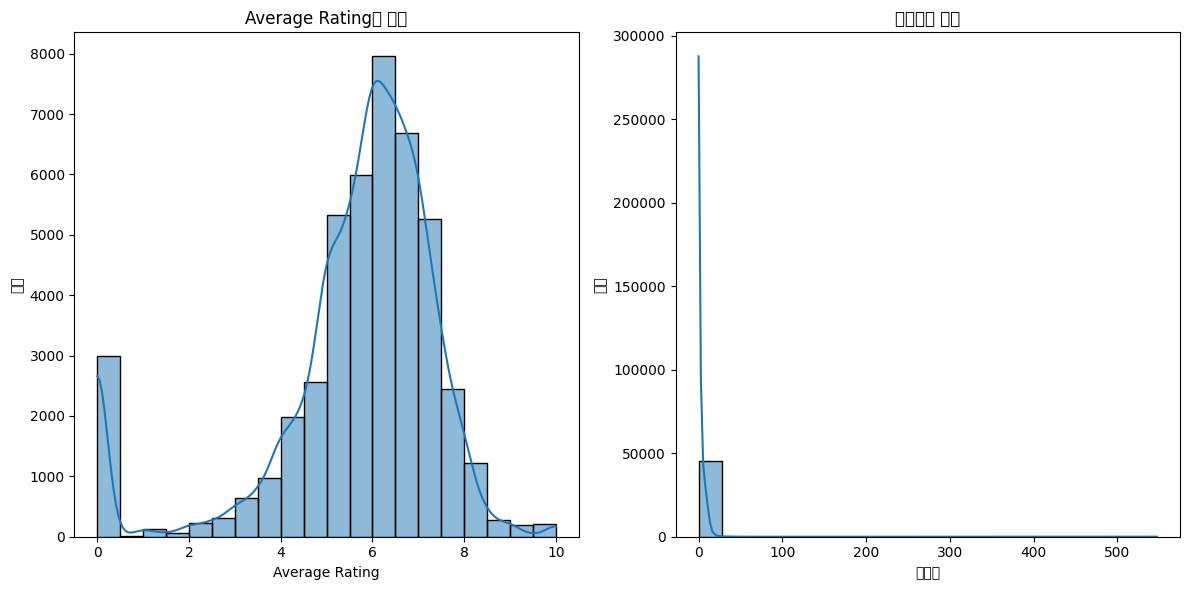

In [29]:
# 새 그림을 생성하고 서브플롯을 설정합니다
plt.figure(figsize=(12, 6))

# 첫 번째 서브플롯: 평균 평점의 분포
plt.subplot(1, 2, 1)  # 1행 2열의 첫 번째 서브플롯
sns.histplot(df['vote_average'], bins=20, kde=True)
plt.title('Average Rating의 분포')
plt.xlabel('Average Rating')
plt.ylabel('빈도')

# 두 번째 서브플롯: 인기도의 분포
plt.subplot(1, 2, 2)  # 1행 2열의 두 번째 서브플롯
sns.histplot(df['popularity'], bins=20, kde=True)
plt.title('인기도의 분포')
plt.xlabel('인기도')
plt.ylabel('빈도')

# 레이아웃 조정
plt.tight_layout()
plt.show()

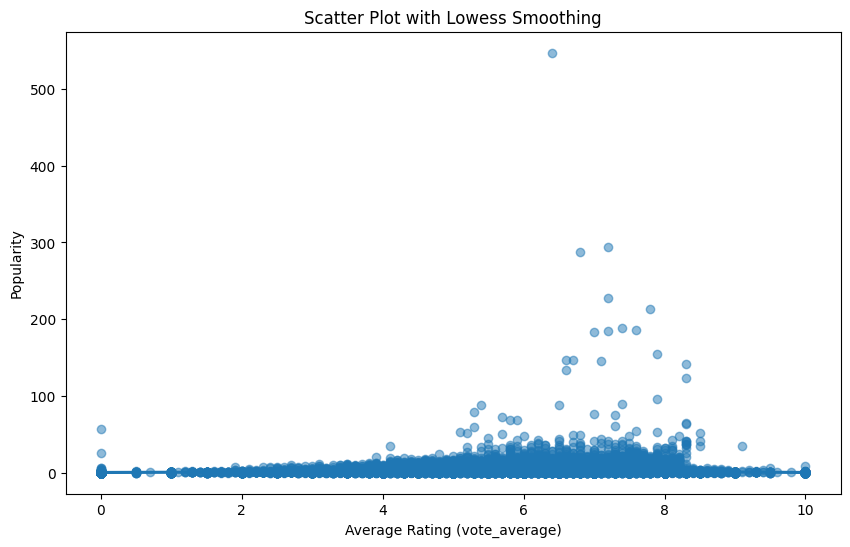

In [31]:
plt.figure(figsize=(10, 6))
sns.regplot(x='vote_average', y='popularity', data=df, scatter_kws={'alpha':0.5}, lowess=True)
plt.title('Scatter Plot with Lowess Smoothing')
plt.xlabel('Average Rating (vote_average)')
plt.ylabel('Popularity')
plt.show()

#2.장르
장르가 여러 개일 경우, 장르를 분리하여 각 장르별로 평균 평점을 계산해야 합니다. 이 과정에서는 장르 열이 리스트 형태로 되어 있다고 가정합니다.

In [89]:
# 데이터프레임을 읽지 않고 열 이름만 확인하기
df_check = pd.read_csv("/content/drive/MyDrive/영등포AI_파이썬/sesac_AI/sesac_AI/9.미니프로젝트8명/데이터셋/movies_metadata.csv/movies_metadata.csv", nrows=0)
print(df_check.columns)

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')


In [90]:
# CSV 파일을 DataFrame으로 로드
#df = pd.read_csv("/content/drive/MyDrive/영등포AI_파이썬/sesac_AI/sesac_AI/9.미니프로젝트8명/수정된데이터셋/movies_metadata.csv/movies_metadata.csv")
#The movie date 셋 이용
# 1. 결측치가 있는 행 자체를 삭제
df_genre = pd.read_csv("/content/drive/MyDrive/영등포AI_파이썬/sesac_AI/sesac_AI/9.미니프로젝트8명/수정된데이터셋/movies_metadata.csv",
                            low_memory=False)[['original_title','popularity','vote_average','genre_id','genre_name' ]].set_index('genre_id').dropna()

print('Shape Movie-Metadata:\t{}'.format(df_genre.shape))
df_genre.sample(5)

df_genre['popularity'] = pd.to_numeric(df_genre['popularity'], errors='coerce')
#인기도 항목 타입 : object->float로 변경

Shape Movie-Metadata:	(416557, 4)


1.2. 여러 장르를 가진 경우
장르가 여러 개일 경우, 장르를 분리하여 각 장르별로 평균 평점을 계산해야 합니다. 이 과정에서는 장르 열이 리스트 형태로 되어 있다고 가정합니다.

In [93]:
MultiLabelBinarizer

# 장르 리스트를 이진화
mlb = MultiLabelBinarizer()
genre_dummies = mlb.fit_transform(df_genre['genres'].str.split(','))  # ','로 구분된 장르를 리스트로 변환
genre_df = pd.DataFrame(genre_dummies, columns=mlb.classes_)

# 원본 데이터프레임과 병합
df_expanded = df_genre.join(df_genre)

# 장르별 평균 평점 계산
genre_avg_rating = df_expanded.groupby(df_genre.columns.tolist()).agg({'vote_average': 'mean'}).reset_index()
print(genre_avg_rating)

KeyError: 'genres'

In [65]:
df_genres = pd.read_csv("/content/drive/MyDrive/영등포AI_파이썬/sesac_AI/sesac_AI/9.미니프로젝트8명/데이터셋/movies_metadata.csv/movies_metadata.csv",
                            low_memory=False)[['original_title','popularity','vote_average','genre_id' ]].dropna()

print('Shape Movie-Metadata:\t{}'.format(df_genres.shape))
df_genres.sample(5)

KeyError: "['genre_id'] not in index"

In [59]:
# CSV 파일을 DataFrame으로 로드
#df = pd.read_csv("/content/drive/MyDrive/영등포AI_파이썬/sesac_AI/sesac_AI/9.미니프로젝트8명/데이터셋/movies_metadata.csv/movies_metadata.csv")
#The movie date 셋 이용
# 1. 결측치가 있는 행 자체를 삭제
df_genres = pd.read_csv("/content/drive/MyDrive/영등포AI_파이썬/sesac_AI/sesac_AI/9.미니프로젝트8명/데이터셋/movies_metadata.csv/movies_metadata.csv",
                            low_memory=False)[['genre_id','genre_name','vote_average','popularity' ]].set_index('genre_name').dropna()

print('Shape Movie-Metadata:\t{}'.format(df_genres.shape))
df_genres.sample(5)

KeyError: "['genre_id', 'genre_name'] not in index"

In [47]:
df_genres['popularity'] = pd.to_numeric(df_genres['popularity'], errors='coerce')
#인기도 항목 타입 : object->float로 변경

In [48]:
df_genres.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45460 entries, ("[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]", "[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]") to ('[]', '[]')
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   vote_average  45460 non-null  float64
 1   popularity    45460 non-null  float64
dtypes: float64(2)
memory usage: 1.0+ MB


In [49]:
df_genres.describe() #인기도 최대값이 547이나?되면 그래프가 너무 차이가 클거같은데 이상치없애고 다시보는거 해봐야할듯

,vote_average,popularity
count,45460.000000,45460.000000
mean,5.618207,2.921478
std,1.924216,6.005414
min,0.000000,0.000000
25%,5.000000,0.385948
50%,6.000000,1.127685
75%,6.800000,3.678902
max,10.000000,547.488298


In [51]:
# 장르 열이 리스트 형태일 경우
from sklearn.preprocessing import MultiLabelBinarizer

# 장르 리스트를 이진화
mlb = MultiLabelBinarizer()
genre_dummies = mlb.fit_transform(df_genres['genres'].str.split(','))  # ','로 구분된 장르를 리스트로 변환
genre_df = pd.DataFrame(genre_dummies, columns=mlb.classes_)

# 원본 데이터프레임과 병합
df_expanded = df_genres.join(genre_df)

# 장르별 평균 평점 계산
genre_avg_rating = df_expanded.groupby(genre_df.columns.tolist()).agg({'vote_average': 'mean'}).reset_index()
print(genre_avg_rating)


KeyError: 'genres'

In [23]:
# 이상치 확인 (예: IQR 방법을 사용한 이상치 탐지)
Q1 = df[['vote_average', 'popularity']].quantile(0.25)
Q3 = df[['vote_average', 'popularity']].quantile(0.75)
IQR = Q3 - Q1
outliers = ((df[['vote_average', 'popularity']] < (Q1 - 1.5 * IQR)) | (df[['vote_average', 'popularity']] > (Q3 + 1.5 * IQR))).sum()
print(outliers)

vote_average    3603
popularity      4236
dtype: int64


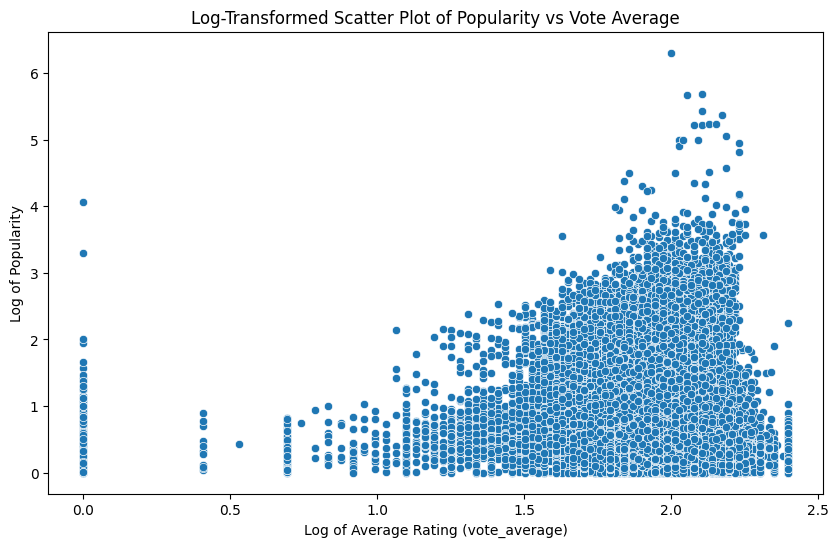

In [26]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.log1p(df['vote_average']), y=np.log1p(df['popularity']), data=df)
plt.title('Log-Transformed Scatter Plot of Popularity vs Vote Average')
plt.xlabel('Log of Average Rating (vote_average)')
plt.ylabel('Log of Popularity')
plt.show()

In [28]:
#상관계수
correlation = df[['vote_average', 'popularity']].corr().iloc[0, 1]
print(f'상관계수: {correlation:.2f}')

상관계수: 0.15


In [16]:
# 평점과 인기 간의 산점도
sns.scatterplot(x='rating', y='popularity', data=df)
plt.xlabel('Rating')
plt.ylabel('Popularity')
plt.title('Rating vs Popularity')
plt.show()

ValueError: Could not interpret value `rating` for `x`. An entry with this name does not appear in `data`.

In [41]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['vote_average'], bins=20, kde=True)
plt.title('Distribution of Vote Average')

plt.subplot(1, 2, 2)
sns.histplot(df['popularity'], bins=20, kde=True)
plt.title('Distribution of Popularity')

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7f7c54c6d3f0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f7c54c6c670> (for post_execute):


KeyboardInterrupt: 

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='rating', palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

ValueError: Could not interpret value `rating` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

In [36]:
# Bar plot
plt.figure(figsize=(25, 8))
sns.barplot(x='vote_average', y='popularity', data=df_clean, palette="Blues_d")
plt.title('Average Popularity by Average Rating (vote_average)')
plt.xlabel('Average Rating (vote_average)')
plt.ylabel('Average Popularity')
plt.xticks()
plt.show()


NameError: name 'df_clean' is not defined

<Figure size 2500x800 with 0 Axes>

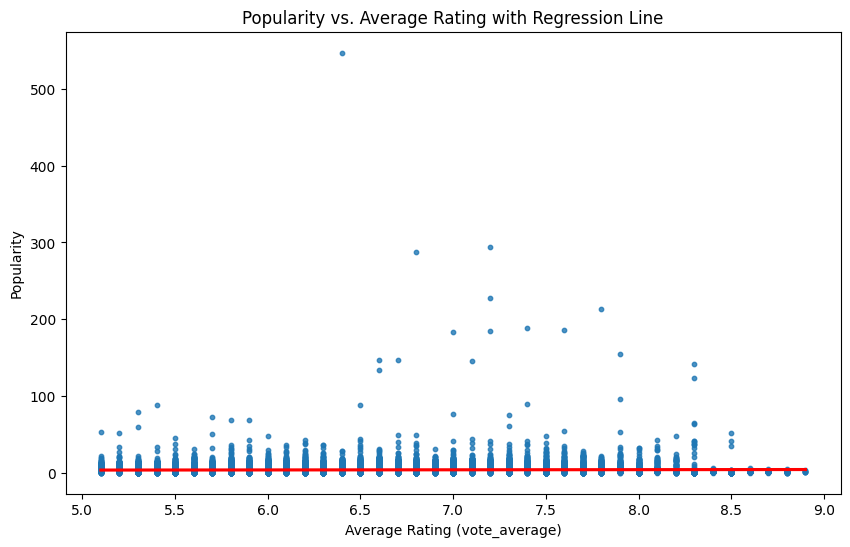

In [34]:
# 특정 범위의 데이터만 필터링하여 사용
df_filtered = df[(df['vote_average'] > 5) & (df['vote_average'] < 9)]

plt.figure(figsize=(10, 6))
sns.regplot(x='vote_average', y='popularity', data=df_filtered, scatter_kws={'s':10}, line_kws={'color':'red'})
plt.title('Popularity vs. Average Rating with Regression Line')
plt.xlabel('Average Rating (vote_average)')
plt.ylabel('Popularity')
plt.show()

In [ ]:
# Identify outliers by defining conditions
high_rating_low_popularity = df_clean[(df_clean['vote_average'] > 7.5) & (df_clean['popularity'] < df_clean['popularity'].mean())]
low_rating_high_popularity = df_clean[(df_clean['vote_average'] < 5.0) & (df_clean['popularity'] > df_clean['popularity'].mean())]

# Display a few examplesprint("Highly Rated but Not Popular Movies:\n", high_rating_low_popularity[['title', 'vote_average', 'popularity']])
print("\nPoorly Rated but Popular Movies:\n", low_rating_high_popularity[['title', 'vote_average', 'popularity']])

3. 데이터 구조 및 정보 확인
데이터의 기본 구조와 내용, 그리고 결측치나 이상치가 있는지 확인합니다.

In [ ]:
# 데이터프레임 정보 확인 (컬럼, 데이터 타입, 결측치 등)
df.info()

# 데이터프레임의 통계 요약 확인
df.describe()

4. 불필요한 컬럼 제거
분석에 필요하지 않은 컬럼을 제거합니다. 예를 들어, 영화의 ID나 URL 등은 분석에 불필요할 수 있습니다.

In [ ]:
# 필요하지 않은 컬럼 리스트
columns_to_drop = ['imdb_id', 'adult', 'homepage', 'poster_path', 'video', 'status']

# 컬럼 제거
df = df.drop(columns=columns_to_drop)

5. 결측치 처리
결측치가 있는 경우, 적절한 방법으로 처리합니다.

In [ ]:
# 결측치가 많은 컬럼을 제거하거나, 결측치가 있는 행을 제거
df = df.dropna(subset=['popularity', 'runtime', 'genres', 'vote_average'])

# 또는 결측치를 특정 값으로 대체 (예: 평균값, 중간값)
df['runtime'] = df['runtime'].fillna(df['runtime'].mean())


6. 데이터 타입 변환
데이터 타입이 잘못된 경우, 이를 올바르게 변환합니다. 예를 들어, release_date를 날짜 형식으로 변환하거나, popularity와 vote_average를 숫자 형식으로 변환합니다

In [ ]:
# release_date를 날짜 형식으로 변환
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# 숫자형 데이터 변환
df['popularity'] = pd.to_numeric(df['popularity'], errors='coerce')
df['vote_average'] = pd.to_numeric(df['vote_average'], errors='coerce')


7. 장르 및 기타 문자열 데이터 처리
장르와 같은 문자열 데이터를 분석 가능한 형식으로 변환합니다. JSON 형식의 문자열을 파싱하거나, 다중 레이블 데이터를 처리할 수 있습니다.

In [ ]:
# 장르 컬럼을 JSON에서 파싱하여, 주요 장르만 추출
import ast

def parse_genres(genres_str):
    genres = ast.literal_eval(genres_str)
    return [genre['name'] for genre in genres]

df['genres'] = df['genres'].apply(parse_genres)

# 장르를 원핫 인코딩
df = df.explode('genres')
df = pd.get_dummies(df, columns=['genres'], prefix='', prefix_sep='')


8. 이상치 탐지 및 제거
상영 시간(runtime)이나 인기도(popularity), 평점(vote_average) 등의 변수에 대해 이상치가 있는지 확인하고, 이를 처리합니다.

In [ ]:
# 상영 시간이 비정상적으로 짧거나 긴 경우 처리
df = df[(df['runtime'] > 0) & (df['runtime'] < 300)]  # 예: 0분보다 크고 300분보다 작은 값만 유지

# 평점이 비정상적으로 높은 경우 제거
df = df[(df['vote_average'] > 0) & (df['vote_average'] <= 10)]


9. 필요한 데이터 추출
분석에 필요한 데이터만 추출하여 새로운 DataFrame을 생성합니다. 예를 들어, 평점과 인기에 집중하고 싶다면 해당 컬럼들만 추출합니다.

In [ ]:
df_analysis = df[['title', 'popularity', 'runtime', 'vote_average']]


10. 데이터 저장 (옵션)
전처리가 완료된 데이터를 CSV 파일로 저장할 수 있습니다.

In [ ]:
df.to_csv('movies_metadata_preprocessed.csv', index=False)


---




#분석

1. Google Colab 환경 설정
Google Colab에 접속하고, 새로운 노트북을 만듭니다.
필요한 라이브러리를 설치 및 임포트합니다.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

2. 데이터 로드
CSV 파일에서 데이터를 로드합니다. 파일을 로컬에서 업로드하거나, Google Drive에서 불러올 수 있습니다.

In [ ]:
# 파일 로컬에서 업로드
from google.colab import files
uploaded = files.upload()

# CSV 파일을 Pandas DataFrame으로 로드
df = pd.read_csv('your_file_name.csv')

# 혹은 구글 드라이브에서 파일을 불러올 경우
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/your_file_name.csv')

3. 데이터 탐색 및 전처리
데이터의 구조를 확인하고, 필요한 컬럼이 있는지 확인합니다. 결측치가 있는지 확인하고, 필요에 따라 처리합니다.

In [ ]:
# 데이터프레임의 첫 5줄을 확인
df.head()

# 데이터프레임의 컬럼 정보 및 결측치 확인
df.info()

# 결측치 처리 (필요 시)
df = df.dropna(subset=['popularity', 'rating'])


4. 평점과 인기 간의 상관관계 분석
상관관계를 분석하고 시각화합니다. corr() 함수를 사용하여 상관 계수를 계산할 수 있습니다.

In [ ]:
# 평점과 인기 간의 상관계수 계산
correlation = df['rating'].corr(df['popularity'])
print(f'평점과 인기 간의 상관계수: {correlation}')

# 상관관계 히트맵 시각화
sns.heatmap(df[['rating', 'popularity']].corr(), annot=True, cmap='coolwarm')
plt.show()


5. 상관관계 해석
상관 계수의 값에 따라 평점과 인기 간의 관계를 해석합니다.
상관계수가 +1에 가까울수록 양의 상관관계, -1에 가까울수록 음의 상관관계를 의미합니다. 0에 가까우면 두 변수 간에 관계가 거의 없다는 뜻입니다.
6. 산점도 그리기
평점과 인기가 어떤 식으로 분포되어 있는지 시각적으로 확인합니다.

In [ ]:
# 평점과 인기 간의 산점도
sns.scatterplot(x='rating', y='popularity', data=df)
plt.xlabel('Rating')
plt.ylabel('Popularity')
plt.title('Rating vs Popularity')
plt.show()


7. 추가 분석 (옵션)
필요하다면 다른 변수들과의 상관관계도 분석하거나, 특정 조건에 따른 그룹별 상관관계를 확인할 수 있습니다.

In [ ]:
# 특정 장르에 따른 그룹별 상관관계 예시
genres = ['Drama', 'Comedy', 'Action']  # 분석하고자 하는 장르 리스트
for genre in genres:
    genre_df = df[df['genre'].str.contains(genre)]
    correlation = genre_df['rating'].corr(genre_df['popularity'])
    print(f'{genre} 장르의 평점과 인기 간의 상관계수: {correlation}')


8. 결과 해석 및 적용
분석 결과를 바탕으로 인사이트를 도출하고, 영화 제작, 마케팅, 배급 전략 등에 반영할 수 있습니다.
이런 과정으로 Colab에서 평점과 인기 간의 상관관계를 분석할 수 있습니다. 결과에 따라 추가적인 분석이나 모델링을 진행할 수 있으며, 이를 통해 영화 성공을 예측하는 데 유용한 데이터를 얻을 수 있습니다.